In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import cv2
import os
import numpy as np
import pathlib
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
import datetime

In [2]:
IMG_HEIGHT = 180
IMG_WIDTH = 180
VIDEO_FOLDER_PATH = 'videos'
PATH_FOR_IMAGES = 'images'
PATH_FOR_IMAGES = pathlib.Path(PATH_FOR_IMAGES)
SEQUENCE_LENGTH=20

VALIDATION_PERCENTAGE = 0.20
TEST_PERCENTAGE = 0.10
TRAIN_PERCENTAGE = 1 - (VALIDATION_PERCENTAGE + TEST_PERCENTAGE)


CLASSES = np.array(sorted([item.name for item in PATH_FOR_IMAGES.glob('*') if item.is_dir()]))


1. (Data Preparation) Extract frames from the video and store in new folder location in project directory

In [ ]:
for folder in os.listdir(VIDEO_FOLDER_PATH):

    # TODO: Check if images folder exists, if not create it
    if not os.path.exists(PATH_FOR_IMAGES):
        os.mkdir(PATH_FOR_IMAGES)
    
    if not os.path.exists(os.path.join(PATH_FOR_IMAGES, folder)):
        os.mkdir(os.path.join(PATH_FOR_IMAGES, folder))

    for video_file in os.listdir(os.path.join(VIDEO_FOLDER_PATH, folder)):
        full_video_path = os.path.join(VIDEO_FOLDER_PATH, folder, video_file)
        video = cv2.VideoCapture(full_video_path)
        success, image = video.read()
        count = 0

        while success:
            # video.set(cv2.CAP_PROP_POS_MSEC,(count*200))
            image_path = os.path.join(PATH_FOR_IMAGES, folder, "frame%d.jpg" % count)
            cv2.imwrite(image_path, image)
            success, image = video.read()
            count += 1

2. (Data Partioning) Create TensorFlow Datasets Objects consisting of images

In [14]:
# Create a dataset dictionary with train, test and validation paritions, where the images are stored in a list
def create_dataset(path):
    dataset = {}
    dataset['train'] = list()
    dataset['test'] = list()
    dataset['validation'] = list()

    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        # Split the images in the folder into train, test and validation sets
        images = [os.path.join(path, folder, item.name) for item in pathlib.Path(folder_path).glob('*') if item.is_file()]
        images = np.array(images)
        split = int(len(images) * TRAIN_PERCENTAGE)
        train_images = images[:split]
        test_images = images[split:]
        validation_split = int(len(test_images) * VALIDATION_PERCENTAGE)
        validation_images = test_images[:validation_split]
        test_images = test_images[validation_split:]

        dataset['train'].extend(train_images)
        dataset['test'].extend(test_images)
        dataset['validation'].extend(validation_images)

        print("Folder: %s, train: %d, test: %d, validation: %d" % (folder, len(train_images), len(test_images), len(validation_images)))
    return dataset
            
dataset = create_dataset(PATH_FOR_IMAGES)

print("Total training images: %d" % len(dataset['train']))
print("Total test images: %d" % len(dataset['test']))
print("Total validation images: %d" % len(dataset['validation']))


Folder: move, train: 820, test: 282, validation: 70
Folder: no_move, train: 1383, test: 475, validation: 118
Total training images: 2203
Total test images: 757
Total validation images: 188


In [4]:
# total_image_count = len(list(PATH_FOR_IMAGES.glob('**/*.jpg')))
# # NOTE: Below does not need to be a tensorflow dataset
# list_ds = tf.data.Dataset.list_files(str(PATH_FOR_IMAGES/'*/*.jpg'), shuffle=False)
# # list_ds = list_ds.shuffle(total_image_count, reshuffle_each_iteration=False)


# validation_set_size = int(total_image_count * VALIDATION_PERCENTAGE)
# training_set_size = int(total_image_count * TRAIN_PERCENTAGE)
# test_set_size = int(total_image_count * TEST_PERCENTAGE)

# training_set = list_ds.take(training_set_size)
# validation_set = list_ds.skip(training_set_size).take(validation_set_size)
# test_set = list_ds.skip(validation_set_size + training_set_size).take(test_set_size)

# print("Amount of Training data: " + str(tf.data.experimental.cardinality(training_set).numpy()))
# print("Amount of Validation data: " + str(tf.data.experimental.cardinality(validation_set).numpy()))
# print("Amount of Test data: " + str(tf.data.experimental.cardinality(test_set).numpy()))



Amount of Training data: 2203
Amount of Validation data: 629
Amount of Test data: 314


3. (Data Pre-processing) Detect person, Create image, label pair data points, augment dataset

In [18]:
def extract_label_from_path(image_path):
    parts = tf.strings.split(image_path, os.path.sep)
    one_hot = tf.dtypes.cast(parts[-2] == CLASSES, tf.int16)
    # NOTE: Converting back tensor to numpy array, as the tensor is not serializable
    return tf.argmax(one_hot).numpy()


def decode_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def process_path(image_path):
    img = tf.io.read_file(image_path)
    img = decode_image(img)
    return img

In [19]:
# Loop through the image path list and load the images in batches containing 20 images
# Each batch is assigned a label based on the predominant class in the batch
# Repeat the process for the entire image path list offsetting the iteration by the sequence length
def create_dataset(list_of_images):
    full_dataset_images = []
    full_dataset_labels = []
    temp_set = []
    temp_labels = []
    for image_path in list_of_images:
        if len(temp_set) == SEQUENCE_LENGTH:
            main_label = max(set(temp_labels), key=temp_labels.count)
            full_dataset_images.append(temp_set)
            full_dataset_labels.append(main_label)
            temp_set = []
            temp_labels = []
        else:
            temp_set.append(process_path(image_path))
            temp_labels.append(extract_label_from_path(image_path))
    return np.asarray(full_dataset_images), tf.keras.utils.to_categorical(np.asarray(full_dataset_labels))

In [20]:
# Create tensorflow dataset object from the dataset dictionary
# NOTE: This is a tensorflow dataset object

train_ds = create_dataset(dataset['train'])
validation_ds = create_dataset(dataset['validation'])
test_ds = create_dataset(dataset['test'])

# training_set = tf.data.Dataset.from_tensor_slices(dataset['train'])
# validation_set = tf.data.Dataset.from_tensor_slices(dataset['validation'])
# test_set = tf.data.Dataset.from_tensor_slices(dataset['test'])



In [21]:
for i in train_ds:
    print(i)

[[[[[0.3190632  0.47200438 0.2563181 ]
    [0.30980393 0.47058827 0.2509804 ]
    [0.30435732 0.46514165 0.24553378]
    ...
    [0.32156864 0.48747286 0.28779945]
    [0.32091495 0.4859477  0.28888875]
    [0.30980393 0.4750545  0.27734208]]

   [[0.31960785 0.4803922  0.26078433]
    [0.3124183  0.47320265 0.2535948 ]
    [0.3019608  0.46274513 0.24313727]
    ...
    [0.32156864 0.4901961  0.2767972 ]
    [0.31732023 0.4859477  0.27516326]
    [0.31176472 0.4803922  0.26895428]]

   [[0.3137255  0.48627454 0.25490198]
    [0.30653596 0.479085   0.24771243]
    [0.29803923 0.47058827 0.2392157 ]
    ...
    [0.32352942 0.5        0.2701524 ]
    [0.3212418  0.4977124  0.26960772]
    [0.31960785 0.49607846 0.26753816]]

   ...

   [[0.2137255  0.35490197 0.18235295]
    [0.21568629 0.35686275 0.18431373]
    [0.20904142 0.35021788 0.17766884]
    ...
    [0.27603474 0.44858378 0.24858376]
    [0.2784314  0.45098042 0.2509804 ]
    [0.2784314  0.45098042 0.2509804 ]]

   [[0.21514162 

In [22]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size=32)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
validation_ds = configure_for_performance(validation_ds)



AttributeError: 'tuple' object has no attribute 'cache'

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
print(image_batch.shape)

for j, images in enumerate(image_batch):
    for i in range(9):
     ax = plt.subplot(3, 3, i + 1)
     plt.imshow(images[i].numpy().astype("uint8"))
     label = label_batch[j][i]
     plt.title(CLASSES[label])
     plt.axis("off")


4. (Model Implementation) Neural Network Implementation
* We might not need to actually shuffle the dataset as we want to capture temporal relationship
* Need to consider the sequence length 


In [27]:
model = keras.Sequential()

model.add(keras.layers.ConvLSTM2D(filters=16, kernel_size=(3, 3), activation="tanh",  padding='same', recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.2)))

model.add(keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), activation="tanh",  padding='same', recurrent_dropout=0.2, return_sequences=True))
model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.2)))

model.add(keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), activation="tanh",  padding='same', recurrent_dropout=0.2, return_sequences=True))
model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.2)))

model.add(keras.layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), activation="tanh",  padding='same', recurrent_dropout=0.2, return_sequences=True))
model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(2, activation="sigmoid"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_4 (ConvLSTM2D)  (None, 20, 180, 180, 16)  11008     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 20, 90, 90, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 90, 90, 16)    0         
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 20, 90, 90, 32)    55424     
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 20, 45, 45, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 45, 45, 32)    0         
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, 20, 45, 45, 64)   

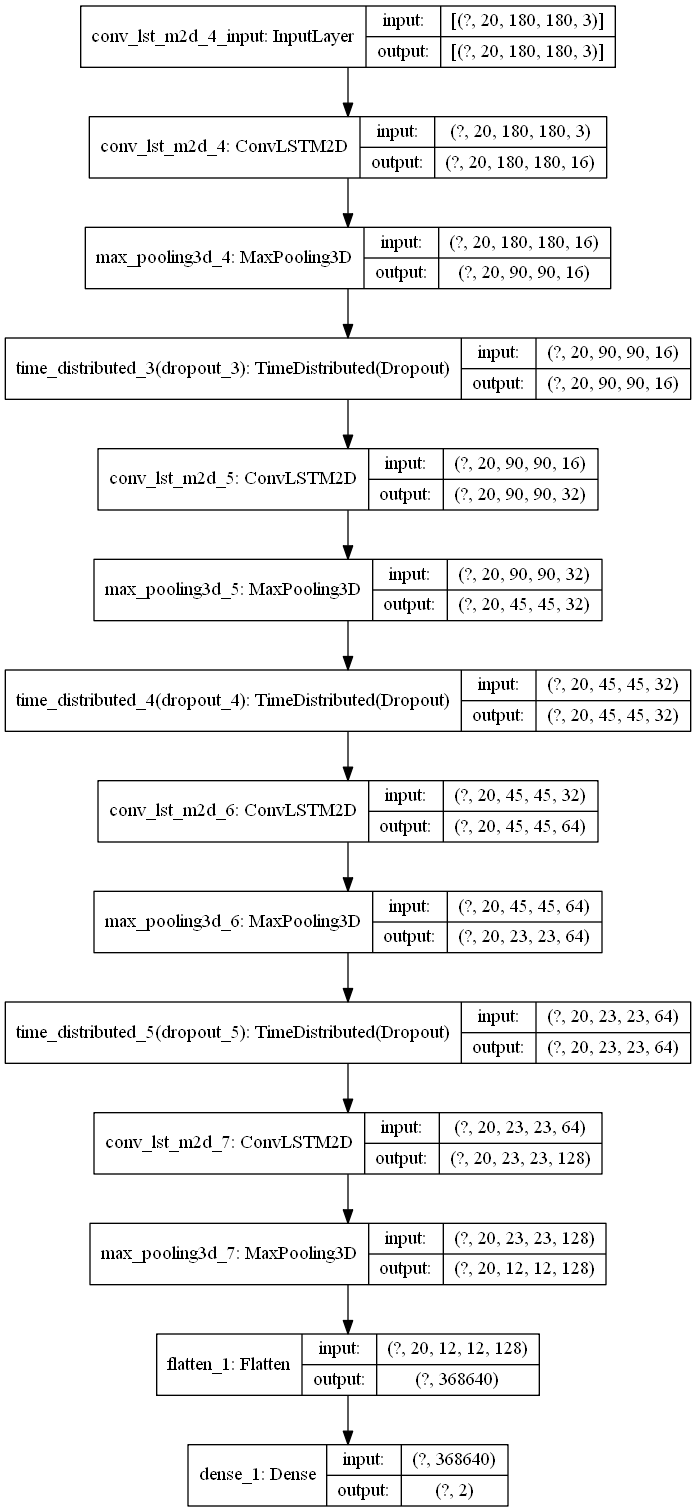

In [28]:
plot_model(model, to_file='model.png', show_shapes=True)

In [29]:
# Training Visualisation with TensorBoard
path = log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=path, histogram_freq=1, update_freq='epoch')

In [30]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
hist = model.fit(x=train_ds[0], y=train_ds[1], epochs=100, batch_size=10, validation_data=validation_ds, callbacks=[tensorboard_callback])

Epoch 1/100
11/11 [==============================] - 24s 2s/step - loss: 5.9558 - accuracy: 0.6250 - val_loss: 6.0443 - val_accuracy: 0.6250
Epoch 2/100
11/11 [==============================] - 13s 1s/step - loss: 6.0443 - accuracy: 0.6250 - val_loss: 6.0443 - val_accuracy: 0.6250
Epoch 3/100
11/11 [==============================] - 13s 1s/step - loss: 6.0443 - accuracy: 0.6250 - val_loss: 6.0443 - val_accuracy: 0.6250
Epoch 4/100
11/11 [==============================] - 13s 1s/step - loss: 6.0443 - accuracy: 0.6250 - val_loss: 6.0443 - val_accuracy: 0.6250
Epoch 5/100
11/11 [==============================] - 13s 1s/step - loss: 6.0443 - accuracy: 0.6250 - val_loss: 6.0443 - val_accuracy: 0.6250
Epoch 6/100
11/11 [==============================] - 13s 1s/step - loss: 6.0443 - accuracy: 0.6250 - val_loss: 6.0443 - val_accuracy: 0.6250
Epoch 7/100
11/11 [==============================] - 13s 1s/step - loss: 6.0443 - accuracy: 0.6250 - val_loss: 6.0443 - val_accuracy: 0.6250
Epoch 8/100
1

In [ ]:
# Evaluate trained model on test dataset
# model.evaluate(test_batches)cey